<a href="https://colab.research.google.com/github/oliveirasWell/mlp/blob/master/MLP_RBF_Adult_income_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Wellington de Oliveira dos Santos
# Adult Data Set
#
# http://www.cs.toronto.edu/~delve/data/adult/desc.html
#
# 
#
#

In [3]:
install.packages("reshape2")
install.packages("Hmisc")
library(reshape2)
library(Hmisc)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units




In [4]:
quantidade.colunas <- function(matriz){
  return(ncol(t(t(matriz))))
}

In [5]:
# Primeiro vamos implementar uma função de ativação
funcao.ativacao <- function(v){

  # Função logística
  y <- 1 / (1 + exp(-v))

  return(y)
}

In [6]:
# Vamos também precisar da derivada da função de ativação
der.funcao.ativacao <- function(y){

  # Derivada da logística
  derivada <- y * (1 - y)

  return(derivada)
}

In [7]:
# Vamos criar uma arquitetura para nossa MLP
arquitetura <- function(num.entrada, num.escondida, num.saida,
                        funcao.ativacao, der.funcao.ativacao){

  arq <- list()

  # Parametros da rede    
  arq$num.entrada <- num.entrada
  arq$num.escondida <- num.escondida
  arq$num.saida <- num.saida
  arq$funcao.ativacao <- funcao.ativacao
  arq$der.funcao.ativacao <- der.funcao.ativacao

  # 2 neuronios na camada escondida
  # 
  #       Ent1    Ent2   Bias 
  # 1     w11     w12    w13
  # 2     w21     w22    w23

  # Pesos conectando entrada e escondida
  num.pesos.entrada.escondida <- (num.entrada+1)*num.escondida
  arq$escondida <- matrix(runif(min=-0.5,max=0.5, num.pesos.entrada.escondida),
                                nrow=num.escondida, ncol=num.entrada+1)

  # Pesos conectando escondida e saida
  num.pesos.escondida.saida <- (num.escondida+1)*num.saida
  arq$saida <- matrix(runif(min=-0.5,max=0.5,  num.pesos.escondida.saida),
                            nrow=num.saida, ncol=num.escondida+1)


  return(arq)
}

In [8]:
# Precisamos de um código para a fase de propagação da MLP

mlp.propagacao <- function(arq, exemplo){

  # Entrada -> Cama Escondida
  v.entrada.escondida <- arq$escondida %*% as.numeric(c(exemplo,1))
  y.entrada.escondida <- arq$funcao.ativacao(v.entrada.escondida)

  # Camada Escondida -> Camada de Saida
  v.escondida.saida <- arq$saida %*% c(y.entrada.escondida,1)
  y.escondida.saida <- arq$funcao.ativacao(v.escondida.saida)

  # Resultados
  resultado <- list()
  resultado$v.entrada.escondida <- v.entrada.escondida
  resultado$y.entrada.escondida <- y.entrada.escondida
  resultado$v.escondida.saida <- v.escondida.saida
  resultado$y.escondida.saida <- y.escondida.saida

  return(resultado)
}


In [9]:
# Agora o código para a fase de treinamento da MLP, usando o algoritmo Back-propagation
mlp.retropropagacao <- function(arq, dados, n, limiar){

  erroQuadratico <- 2 * limiar
  epocas <- 0

  # Treina eqto o erro quadratico for maior que um limiar
  while(erroQuadratico > limiar){
    erroQuadratico <- 0

    # Treino para todos os exemplos (epoca)
    for(i in 1:nrow(dados)){

      # Pego um exemplo de entrada
      x.entrada <- dados[i,1:arq$num.entrada]
      x.saida <- dados[i,ncol(dados)]

      # Pego a saida da rede para o exemplo
      resultado <- mlp.propagacao(arq,x.entrada)
      y <- resultado$y.escondida.saida

      # Calculo do erro para o exemplo
      print(x.saida)
      print(y)

      erro <- x.saida - y

      # Soma erro quadratico
      erroQuadratico <- erroQuadratico + erro*erro

      # Gradiente local no neuronio de saida
      # erro * derivada da funcao de ativacao
      grad.local.saida <- erro * arq$der.funcao.ativacao(y)

      # Gradiente local no neuronio escondido
      # derivada da funcao de ativacao no neuronio escondido * soma dos gradientes
      # locais dos neuronios conectados na proxima camada * pesos conectando a camada
      # escondida com a saida
      pesos.saida <- arq$saida[,1:arq$num.escondida]
      grad.local.escondida <-
        as.numeric(arq$der.funcao.ativacao(resultado$y.entrada.escondida)) *
        (grad.local.saida %*% pesos.saida)

      # Ajuste dos pesos
      # Saida
      arq$saida <- arq$saida + n * (grad.local.saida %*%
                                     c(resultado$y.entrada.escondida,1))
      # Escondida
      arq$escondida <- arq$escondida + n * (t(grad.local.escondida) %*%
                                             as.numeric(c(x.entrada,1)))
    } # Fim for(i in 1:nrow(dados))

    print(nrow(dados))
    erroQuadratico <- erroQuadratico / nrow(dados)
    cat("Erro Quadratico Medio = ",erroQuadratico, "\n")
    epocas <- epocas+1
    
  } # Fim while(erroQuadratico > limiar)

  retorno <- list()
  retorno$arq <- arq
  retorno$epocas <- epocas

  return(retorno)
}

In [10]:
# Leitura de uma tabela com os dados do problema XOR
dados <- read.csv('sample_data/adult.data', header=FALSE, strip.white=TRUE)
head(dados)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>
1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [11]:
colnames(dados) <- c("age",
                     "workclass", 
                     "fnlwgt",
                     "education",
                     "education-num",
                     "marital",
                      "occupation",
                      "relationship",
                      "race",
                      "sex", 
                      "capital-gain", 
                      "capital-loss",
                      "hours-per-week",
                      "country",
                      "income"
)

dim(dados)
summary(dados)

[1] 32561    15

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education-num     marital           occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

In [12]:
str(dados)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education-num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital       : chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation    : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship  : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race          : chr  "White" "White" "White" "Black" ...
 $ sex           : chr  "Male" "Male" "Male" "Male" ...
 $ capital-gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital-loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours-per-week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ country       : chr  "United-States" "Uni

In [13]:
prop.table(table(dados$income))


    <=50K      >50K 
0.7591904 0.2408096 

In [14]:
#dados$education <- as.factor(dados$education)
#dados$workclass <- as.factor(dados$workclass)
#dados$occupation <- as.factor(dados$occupation)
#dados$relationship <- as.factor(dados$relationship)
#dados$race <- as.factor(dados$race)
#dados$sex <- as.factor(dados$sex)
#dados$income <- as.factor(dados$income)
#dados$"marital-status" <- as.factor(dados$"marital-status")
#dados$"native-country" <- as.factor(dados$"native-country")

str(dados)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  "State-gov" "Self-emp-not-inc" "Private" "Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  "Bachelors" "Bachelors" "HS-grad" "11th" ...
 $ education-num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital       : chr  "Never-married" "Married-civ-spouse" "Divorced" "Married-civ-spouse" ...
 $ occupation    : chr  "Adm-clerical" "Exec-managerial" "Handlers-cleaners" "Handlers-cleaners" ...
 $ relationship  : chr  "Not-in-family" "Husband" "Not-in-family" "Husband" ...
 $ race          : chr  "White" "White" "White" "Black" ...
 $ sex           : chr  "Male" "Male" "Male" "Male" ...
 $ capital-gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital-loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours-per-week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ country       : chr  "United-States" "Uni

In [15]:

# Vamos remover elementos nulos 

# a. Número de exemplos
8080
# b. Número de atributos
dim(dados)

[1] 8080

[1] 32561    15

In [16]:
# c. Número de atributos numéricos
print(6)


[1] 6


In [17]:

# d. Número de atributos categóricos
print(9)


[1] 9


In [18]:
# e. Número de atributos com valores ausentes

length(dados[dados == "?"])


[1] 4262

In [19]:
# Ajusta os dados de saída 
# Não muito balanceado
# "<=50K",">50K"

dados$income[dados$income == "<=50K"] <- 1
dados$income[dados$income == ">50K"] <- 0

dados$income = as.numeric(as.character(dados$income))

table(dados$income)


    0     1 
 7841 24720 

In [20]:
# Arrumando os dados faltantes 
# Foi utilizada a estratégia de moda para todos os elementos

dados$workclass[dados$workclass == "?"] <- mode(dados$workclass)
table(dados$workclass)


       character      Federal-gov        Local-gov     Never-worked 
            1836              960             2093                7 
         Private     Self-emp-inc Self-emp-not-inc        State-gov 
           22696             1116             2541             1298 
     Without-pay 
              14 

In [21]:
dados$education[dados$education == "?"] <- mode(dados$education)
table(dados$education)


        10th         11th         12th      1st-4th      5th-6th      7th-8th 
         933         1175          433          168          333          646 
         9th   Assoc-acdm    Assoc-voc    Bachelors    Doctorate      HS-grad 
         514         1067         1382         5355          413        10501 
     Masters    Preschool  Prof-school Some-college 
        1723           51          576         7291 

In [22]:
dados$occupation[dados$occupation == "?"] <- mode(dados$occupation)
table(dados$occupation)


     Adm-clerical      Armed-Forces         character      Craft-repair 
             3770                 9              1843              4099 
  Exec-managerial   Farming-fishing Handlers-cleaners Machine-op-inspct 
             4066               994              1370              2002 
    Other-service   Priv-house-serv    Prof-specialty   Protective-serv 
             3295               149              4140               649 
            Sales      Tech-support  Transport-moving 
             3650               928              1597 

In [23]:
dados$relationship[dados$relationship == "?"] <- mode(dados$relationship)
table(dados$relationship)


       Husband  Not-in-family Other-relative      Own-child      Unmarried 
         13193           8305            981           5068           3446 
          Wife 
          1568 

In [24]:
dados$race[dados$race == "?"] <- mode(dados$race)
table(dados$race)


Amer-Indian-Eskimo Asian-Pac-Islander              Black              Other 
               311               1039               3124                271 
             White 
             27816 

In [25]:
dados$sex[dados$sex == "?"] <- mode(dados$sex)
table(dados$sex)


Female   Male 
 10771  21790 

In [26]:
dados$"marital"[dados$"marital"  == "?"] <- mode(dados$"marital" )
table(dados$"marital")


             Divorced     Married-AF-spouse    Married-civ-spouse 
                 4443                    23                 14976 
Married-spouse-absent         Never-married             Separated 
                  418                 10683                  1025 
              Widowed 
                  993 

In [27]:
dados$"country"[dados$"country" == "?"] <- mode(dados$"country")
table(dados$"country")


                  Cambodia                     Canada 
                        19                        121 
                 character                      China 
                       583                         75 
                  Columbia                       Cuba 
                        59                         95 
        Dominican-Republic                    Ecuador 
                        70                         28 
               El-Salvador                    England 
                       106                         90 
                    France                    Germany 
                        29                        137 
                    Greece                  Guatemala 
                        29                         64 
                     Haiti         Holand-Netherlands 
                        44                          1 
                  Honduras                       Hong 
                        13                         20 
         

In [28]:
# Constatando que eliminamos todos os elementos nulos do conjunto
length(dados[dados == "?"])

[1] 0

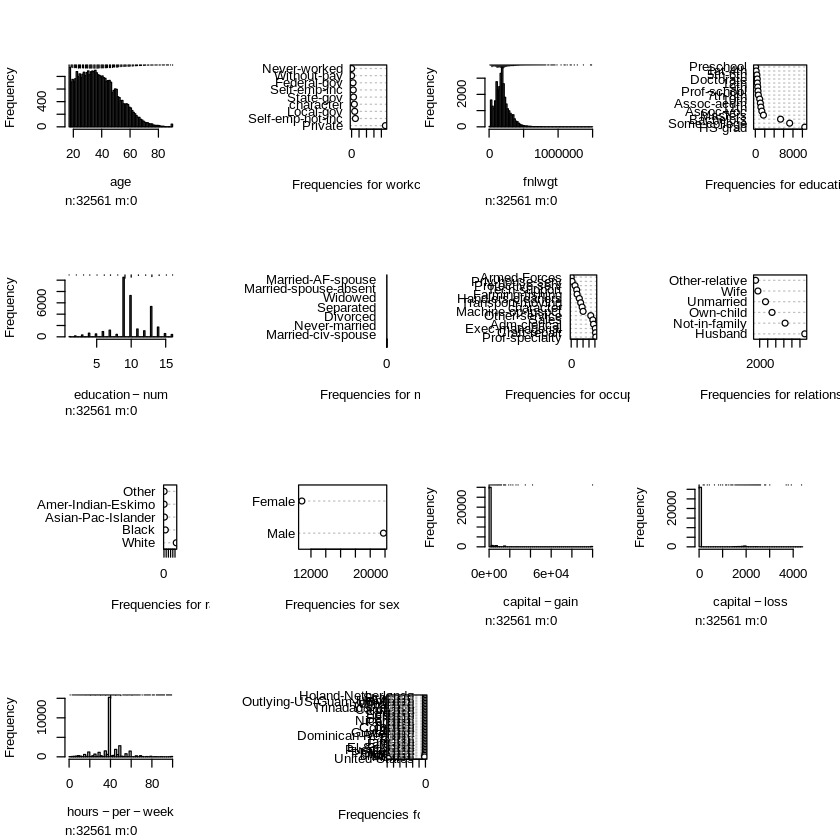

In [29]:
hist.data.frame(dados, na.big = TRUE, rugs = TRUE)

In [30]:
# remove columnas que não conseguimos tratar

dados <-  subset( dados, select = -education )
dados <-  subset( dados, select = -occupation )
dados <-  subset( dados, select = -workclass )
dados <-  subset( dados, select = -relationship )
dados <-  subset( dados, select = -race )
dados <-  subset( dados, select = -sex )
dados <-  subset( dados, select = -marital )
dados <-  subset( dados, select = -country )

#dados$workclass <- NA
#dados$occupation <- NA
#dados$relationship <- NA
#dados$race <- NA
#dados$sex <- NA
#dados$"marital-status" <- NA
#dados$"native-country" <- NA


In [31]:
# Vamos escolher aleatoriamente dados para treino e teste.
# O conjunto de dados já está randomizado. 
# Assim, Vamos pegar os primeiros 1400 exemplos para treino e o restante para teste

#dados.treino <- dados[0:20000,]
#dados.teste <- dados[20000:32560,]

dados.treino <- dados[0:1000,]
dados.teste <- dados[1001:1500,]

In [32]:
head(dados.treino)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,39,77516,13,2174,0,40,1
2,50,83311,13,0,0,13,1
3,38,215646,9,0,0,40,1
4,53,234721,7,0,0,40,1
5,28,338409,13,0,0,40,1
6,37,284582,14,0,0,40,1


In [33]:
# Vamos treinar nossa rede com 4 neurônios na camada escondida
arq <- arquitetura(quantidade.colunas(dados),2,1,funcao.ativacao, der.funcao.ativacao)
print(arq)


$num.entrada
[1] 7

$num.escondida
[1] 2

$num.saida
[1] 1

$funcao.ativacao
function(v){

  # Função logística
  y <- 1 / (1 + exp(-v))

  return(y)
}

$der.funcao.ativacao
function(y){

  # Derivada da logística
  derivada <- y * (1 - y)

  return(derivada)
}

$escondida
           [,1]       [,2]      [,3]       [,4]         [,5]       [,6]
[1,] -0.2507378 -0.4371286 0.4864655  0.3678896 -0.353000618 -0.3709676
[2,] -0.4365850 -0.1727914 0.2793809 -0.3175108  0.000591818  0.3890569
           [,7]        [,8]
[1,] -0.4660489 -0.02061543
[2,]  0.3860328  0.34706569

$saida
           [,1]      [,2]      [,3]
[1,] -0.1528218 0.2293928 0.3916629



In [ ]:
modelo <- mlp.retropropagacao(arq,dados.treino,0.3,1e-3)
print(modelo)

In [ ]:
# Fazendo predicoes para cada exemplo de teste
predicoes <- vector()
for(i in 1:nrow(dados.teste)){

  pred <- mlp.propagacao(modelo$arq,dados.teste[i,1:2])$y.escondida.saida
    
  predicoes <- c(predicoes,pred)
}
print(predicoes)

In [ ]:
# Criando uma matriz para comparação dos resultados
matriz.comparacao <- cbind(dados.teste[,3],predicoes)
colnames(matriz.comparacao) <- c('V','P')
print(matriz.comparacao)

In [ ]:
# Matriz de confusão com o arredondamento das predições
mc <- table(matriz.comparacao[,1],round(matriz.comparacao[,2]))
print(mc)

acc <- sum(diag(mc))/sum(mc)
print(acc)
sum(mc)
sum(diag(mc))

In [ ]:
mat1 <- matrix(runif(min=-1,max=+1,4),nrow=1,ncol=4)
print(mat1)

exe <- c(1,2,0.5,1)
print(exe)

result <- mat1 %*% exe
print(result)

r1 <- mat1[1,1]*1 + mat1[1,2]*2 + mat1[1,3]*0.5 + mat1[1,4]*1
print(r1)
#r2 <- mat1[2,1]*1 + mat1[2,2]*2 + mat1[2,3]*0.5 + mat1[2,4]*1
#print(r2)